# Automated laser locking
In this example, we demonstrate automatic lock acquisition using a Toptica DLC Pro referenced to a Yb vapor cell using modulation transfer spectroscopy.

# Laser control
To control the DLC Pro, we can import the Device from EMERGENT:

In [1]:
from emergent.devices import DLCPro
laser = DLCPro('laser', hub=None, params={'addr': '169.254.120.100'})
laser._connect()

The Device driver has two knobs for the current and piezo voltage. These can be retrieved with the _monitor() method:

In [2]:
laser._monitor()

{'current': 127.0, 'voltage': 36.161616}

The knobs can be set in the usual way, with the actuate() method:

In [3]:
laser.actuate({'current': 123.8, 'piezo': 44})
laser._monitor()

{'current': 123.8, 'voltage': 44.0}

# Wavelength measurement
To get close to the right frequency, we'll use a Bristol 871 wavemeter:

In [4]:
from emergent.devices import Bristol871

w = Bristol871('wavemeter', None, params={'addr':'10.199.199.1', 'port': 23})
w._connect()
w._monitor()

{'frequency': 751518.556}

# Optimizing mode-hop-free tuning range
Before fine-tuning to the target frequency using the piezo, we need to tune the current to ensure mode-hop-free tunability around the target. We'll parameterize the tuning range through the number of points within a threshold of the target frequency when the piezo is swept:

In [5]:
target = 751526
import time
import numpy as np
def scan_piezo(Vmin=41, Vmax=46, steps=30, reverse=False, delay=0):
    V = np.linspace(Vmin, Vmax, steps)
    if reverse:
        V = V[::-1]
    f = np.array([])
    for v in V:
        laser.actuate({'piezo': v})
        time.sleep(delay)
        f = np.append(f, w._monitor()['frequency'])   
        
    bad_indices = np.where(f==None)[0]
    V = np.delete(V, bad_indices)
    f = np.delete(f, bad_indices)
        
    return V, f


In [ ]:
V, f = scan_piezo(Vmin=36, Vmax=44, reverse=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(V, f-target, '.')
plt.xlabel('Piezo voltage (V)')
plt.ylabel('Frequency (GHz)')
plt.show()

## Mode hop detection
To estimate the mode-hop-free tuning range, we can sweep the piezo voltage and monitor the resulting frequency, then numerically locate the mode edges:

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.709000000031665]
[0.4320000000298023]
[]
[]
[]
[]
[]
[]
[]
[]


' TO DO: implement better figure of merit - the range on either side of the target is much more important than the \n    total range, which could be excellent even if the target is right on the edge of the stable range. '

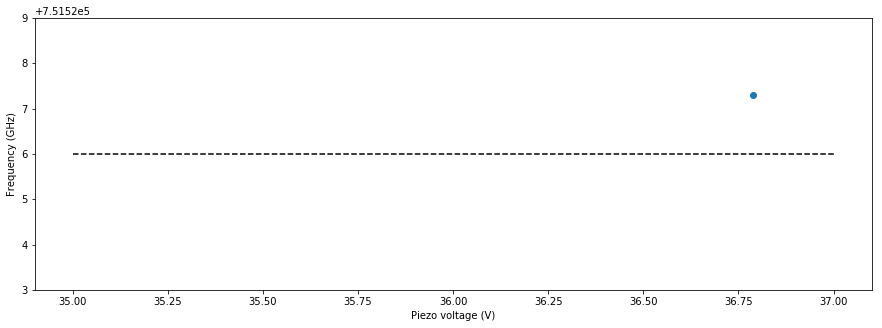

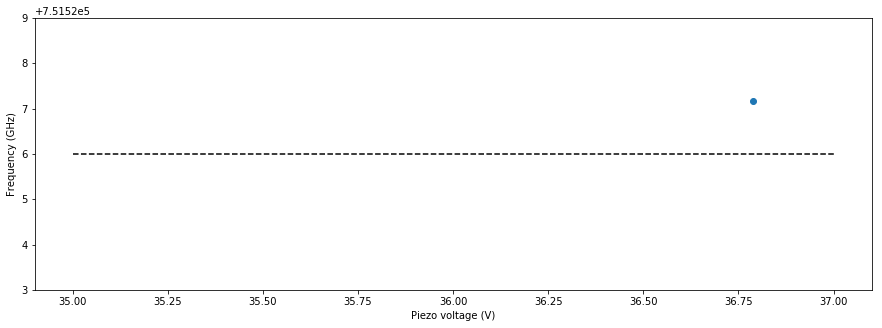

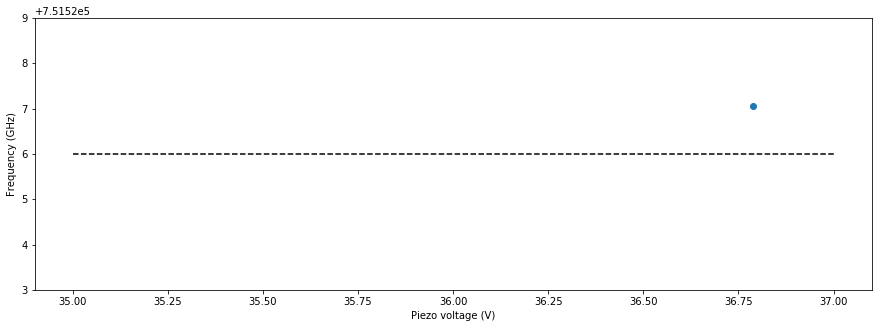

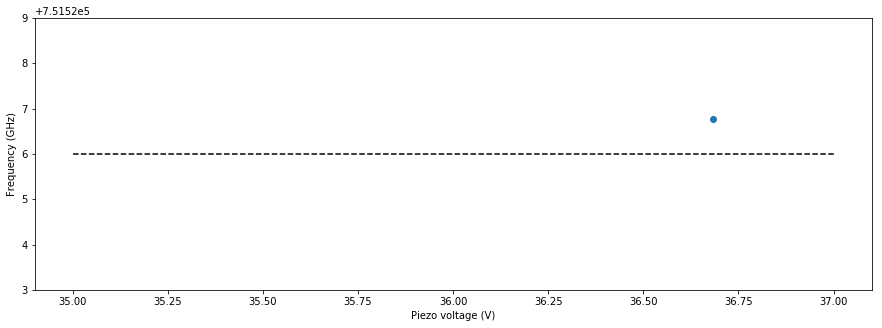

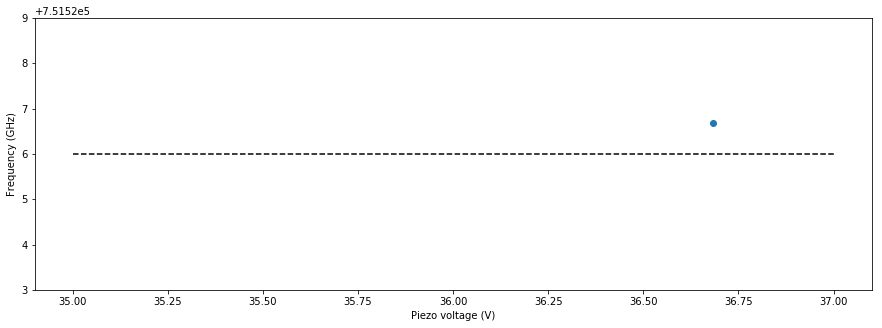

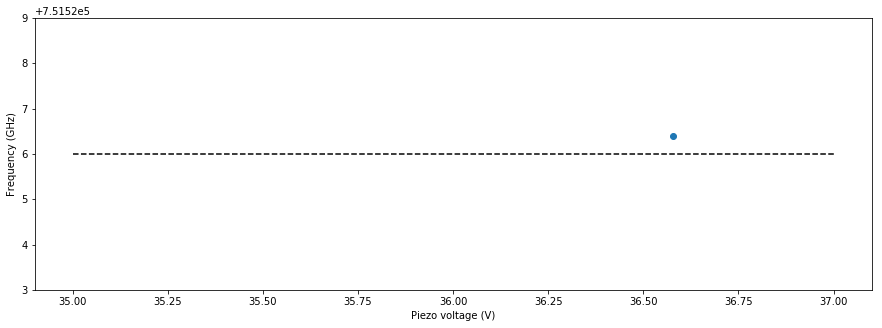

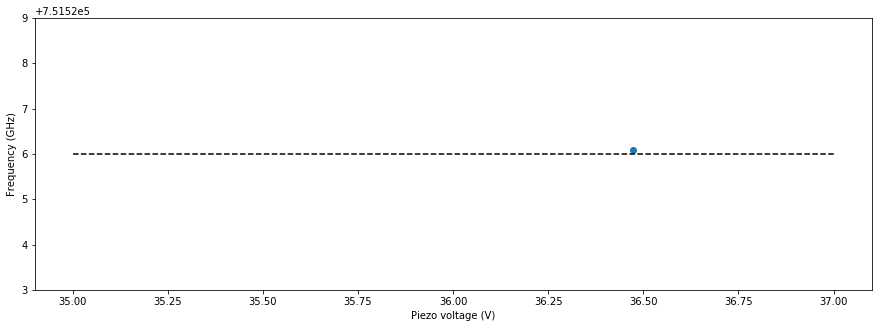

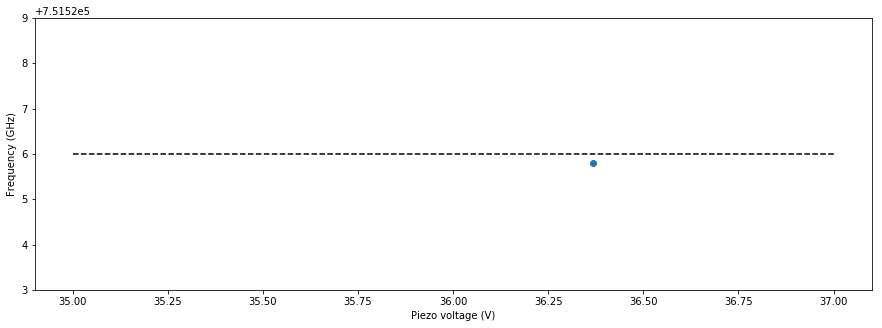

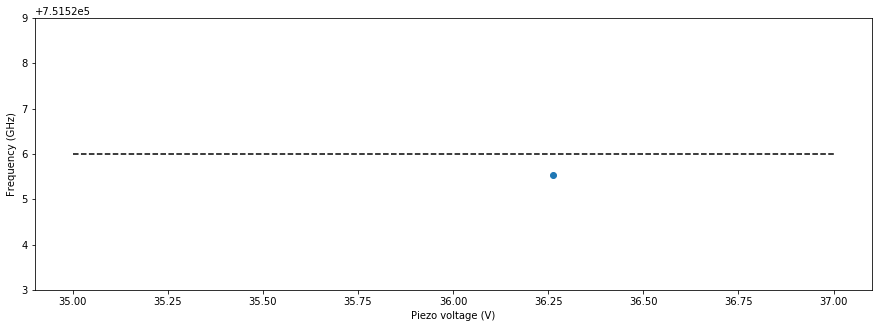

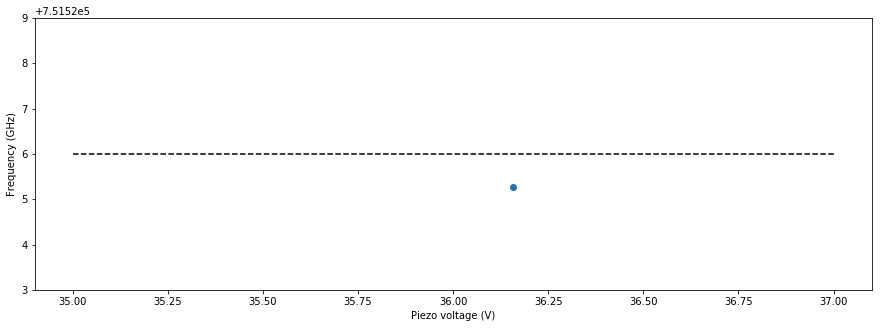

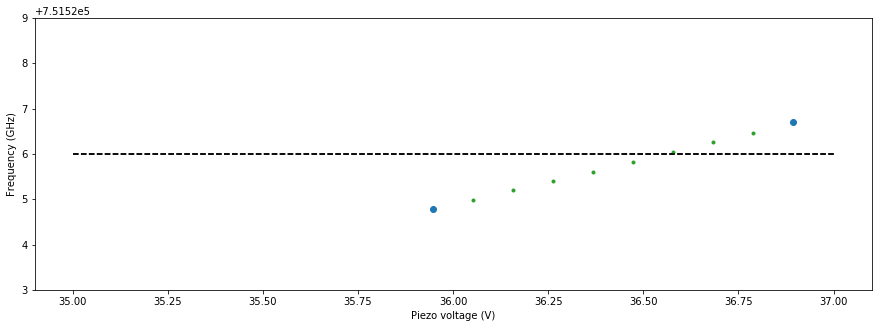

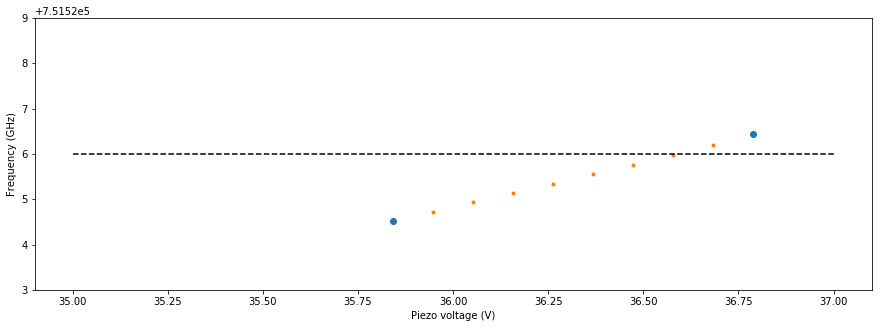

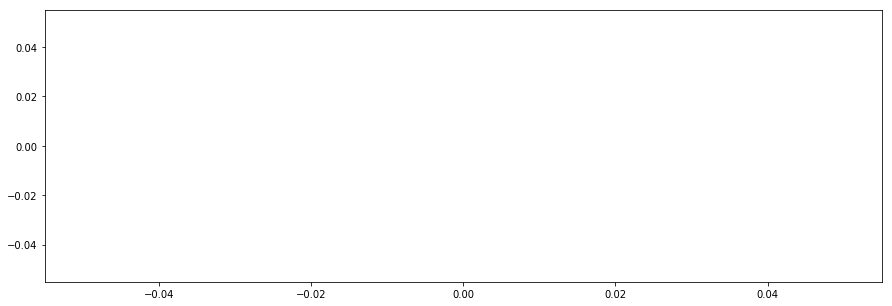

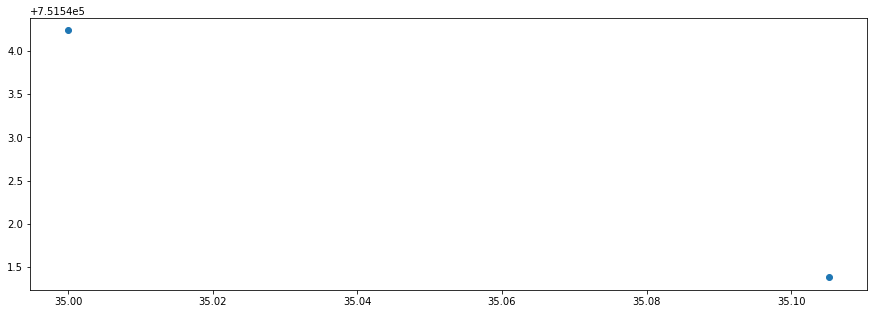

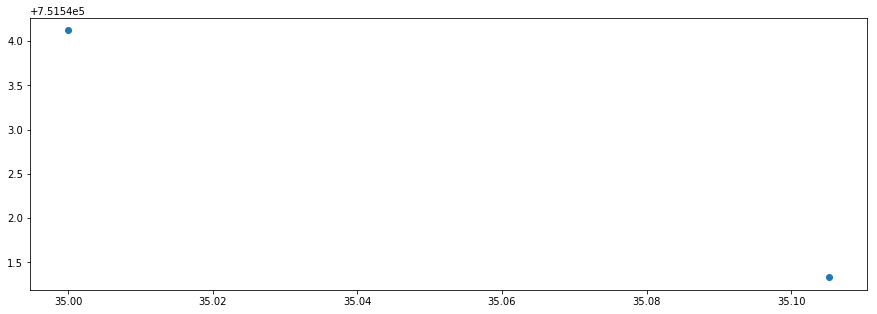

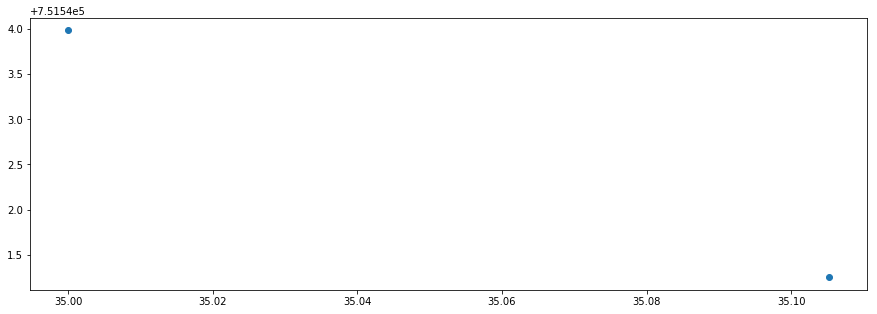

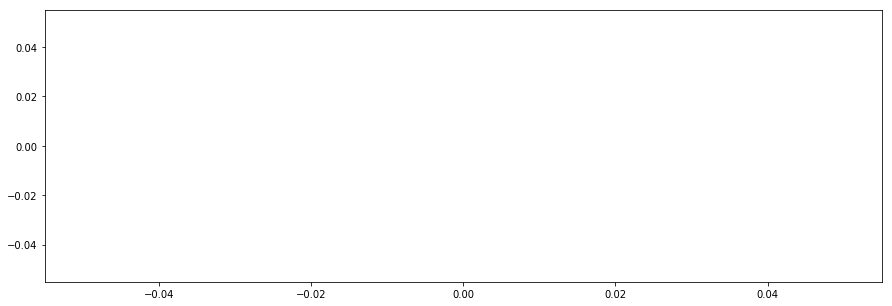

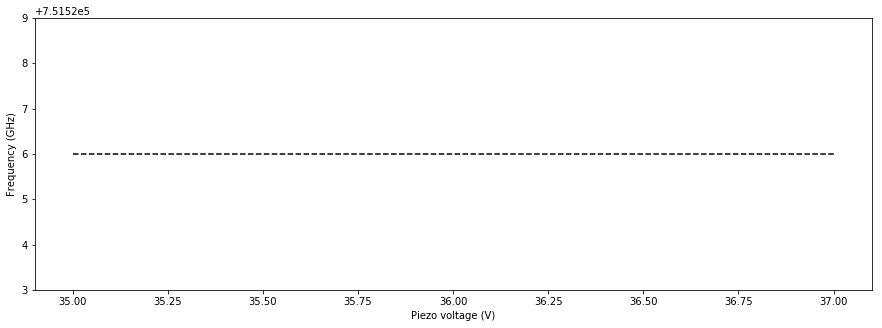

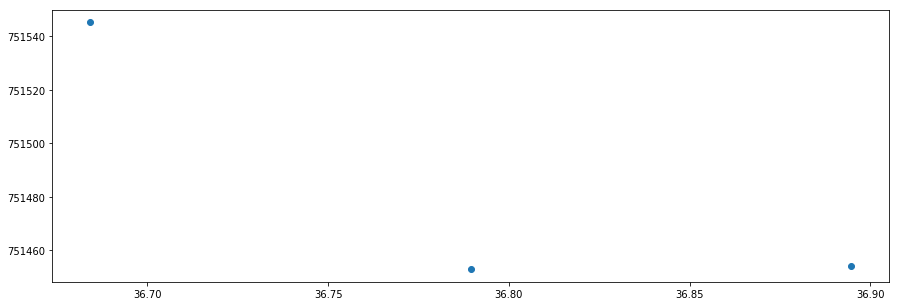

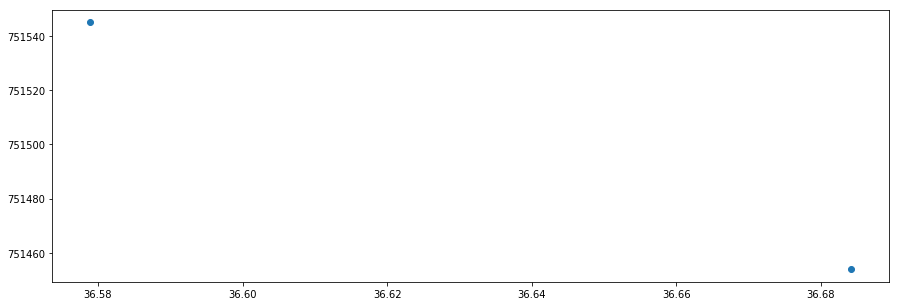

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def find_mode_edges(V,f,threshold=0.05, plot=False):
    ''' Searches for frequency jumps larger than the threshold '''
    diff = np.diff(f)
    hop_indices = np.where(np.abs(diff)>threshold)[0]
    hop_indices = np.append(hop_indices, hop_indices+1)
    hop_indices = np.sort(np.unique(hop_indices))
    hop_frequencies = f[hop_indices]
    hop_voltages = V[hop_indices]

    hops = np.stack([hop_voltages, hop_frequencies]).T
    plt.figure(figsize=(15,5))
    plt.plot(hop_voltages, hop_frequencies, 'o')
    ranges=[]
    modes = []
    for i in range(len(hop_indices)-1):
        ind = hop_indices[i]
        if hop_indices[i+1]-hop_indices[i] > 1:
            ranges.append([hop_indices[i]+1,hop_indices[i+1]])
            modes.append({'Vmin': V[hop_indices[i]+1],
                          'Vmax': V[hop_indices[i+1]],
                          'fmin': f[hop_indices[i]+1],
                          'fmax': f[hop_indices[i+1]]
                         })

    if plot:
        for mode in ranges:
            plt.plot(V[mode[0]:mode[1]], f[mode[0]:mode[1]], '.')
            plt.xlabel('Piezo voltage (V)')
            plt.ylabel('Frequency (GHz)')
            plt.ylim([target-3, target+3])
            
            plt.plot(np.linspace(V.min(), V.max(), 100), np.ones(100)*target, '--k')
        
    widths = []
    for mode in modes:
        if mode['fmin'] < target < mode['fmax']:
            width = np.min([np.abs(mode['fmin']-target), np.abs(mode['fmax']-target)])
            widths.append(width)
            
    print(widths)
    if len(widths)>0:
        return np.max(widths)
    else:
        return 0 

I = np.linspace(128, 129.5, 20)
widths = []
for i in I:
    laser.actuate({'current': i, 'piezo': 36.48})
#     w._monitor()
    V, f = scan_piezo(Vmin=35, Vmax=37, steps=20)
    width = find_mode_edges(V, f, threshold=1, plot=True)
    widths.append(width)
# print(modes)


''' TO DO: implement better figure of merit - the range on either side of the target is much more important than the 
    total range, which could be excellent even if the target is right on the edge of the stable range. '''